# HOMEWORK 06

**Submitted by: Diego Sol**

CSCE 636-600: Deep Learning

Professor: Dr. Anxiao Jiang

**Check out the Jupyter notebooks for Chapter 9 at https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter09_part01_image-segmentation.ipynb, https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter09_part02_modern-convnet-architecture-patterns.ipynb, and https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter09_part03_interpreting-what-convnets-learn.ipynb.**

## Task 1

**Try the code on image segmentation. Show the segmentation result on a randomly selected image. (5 points)**

### Download data and assign file paths

In [14]:
# download and uncompress data
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

# prepare input file paths and corresponding mask file paths
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

--2022-03-30 02:05:51--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2022-03-30 02:05:52--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  11.8MB/s    in 67s     

2022-03-30 02:07:00 (11.4 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2022-03-30 02:07:00--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Co

### Load inputs and targets to create training and validation sets

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

### Create, compile, and train the model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# define the model
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)

# compile the model
model.compile(optimizer="rmsprop", 
              loss="sparse_categorical_crossentropy")

# save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

# train the model
history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 [==============================] - 84s 654ms/step - loss: 1.2014 - val_loss: 0.9776
Epoch 2/50
100/100 [==============================] - 62s 616ms/step - loss: 0.9629 - val_loss: 0.9357
Epoch 3/50
100/100 [==============================] - 61s 614ms/step - loss: 0.8734 - val_loss: 0.8104
Epoch 4/50
100/100 [==============================] - 62s 618ms/step - loss: 0.8360 - val_loss: 0.7432
Epoch 5/50
100/100 [==============================] - 62s 621ms/step - loss: 0.7465 - val_loss: 0.6672
Epoch 6/50
100/100 [==============================] - 62s 622ms/step - loss: 0.6979 - val_loss: 0.6228
Epoch 7/50
100/100 [==============================] - 62s 621ms/step - loss: 0.6401 - val_loss: 0.9498
Epoch 8/50
100/100 [==============================] - 62s 621ms/step - loss: 0.6100 - val_loss: 0.5565
Epoch 9/50
100/100 [==============================] - 62s 620ms/step - loss: 0.5884 - val_loss: 0.7311
Epoch 10/50
100/100 [==============================] - 62s 622ms/step - l

### Plot training and validation loss

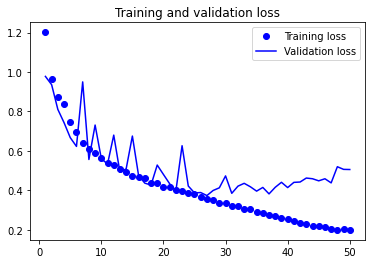

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

### View segmentation mask

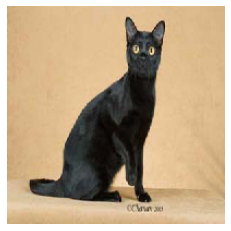

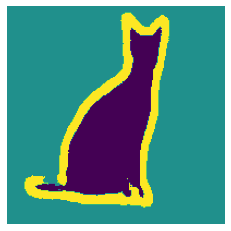

In [ ]:
from tensorflow.keras.utils import array_to_img

plt.figure()
model = keras.models.load_model("oxford_segmentation.keras")

i = random.randrange(0,1000)
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

plt.figure()
mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

## Task 2

**Try the code on "Visualizing intermediate activations". Show the visualization result on a randomly selected image from the cats-and-dogs dataset. (5 points)**

### Load the saved model from `chapter08_intro-to-dl-for-computer-vision.ipynb`

In [23]:
# upload the file "convnet_from_scratch_with_augmentation.keras"
from google.colab import files
files.upload()

Saving convnet_from_scratch_v2.keras to convnet_from_scratch_v2.keras


In [31]:
# load model
from tensorflow import keras
model = keras.models.load_model("convnet_from_scratch_v2.keras")

### Plotting a random image

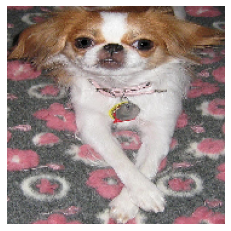

In [32]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# preprocess image
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array
    
img_tensor = get_img_array(np.random.choice(input_img_paths), target_size=(180,180))

# plot image
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

### Instantiating a model that returns layer activations

In [33]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

### Visualize a random channel

(1, 178, 178, 32)


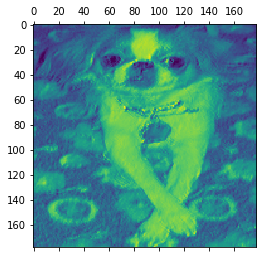

In [34]:
import matplotlib.pyplot as plt

activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

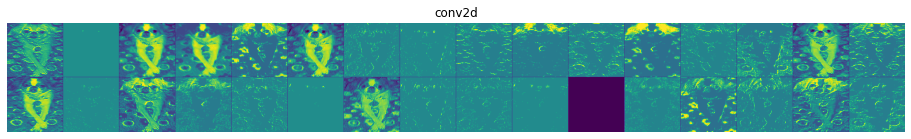

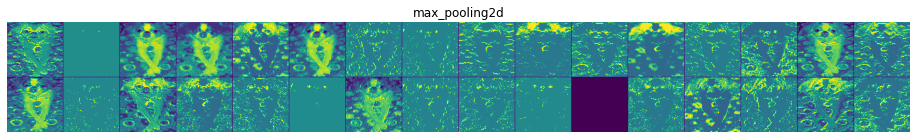

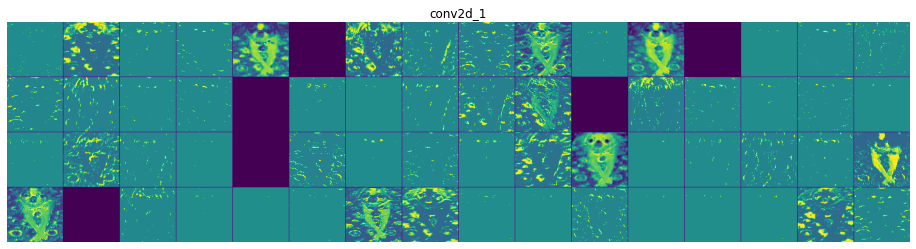

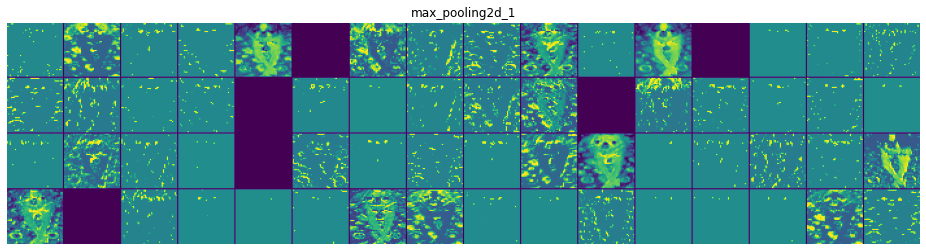

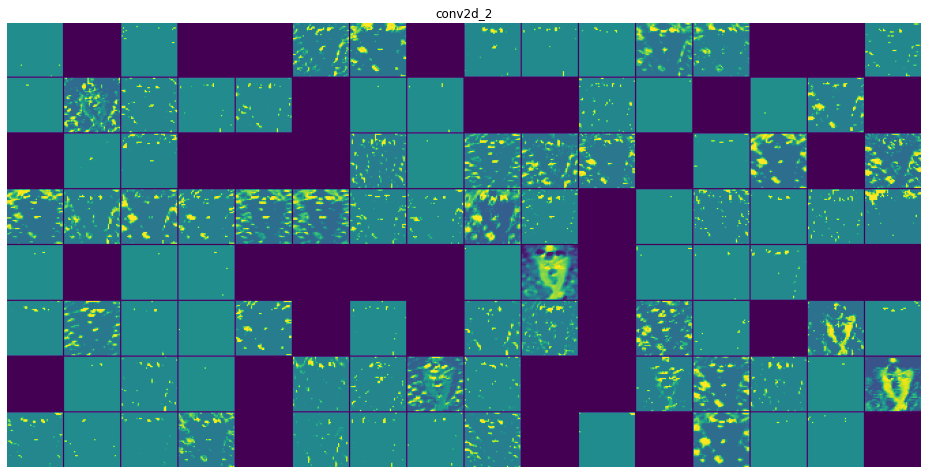

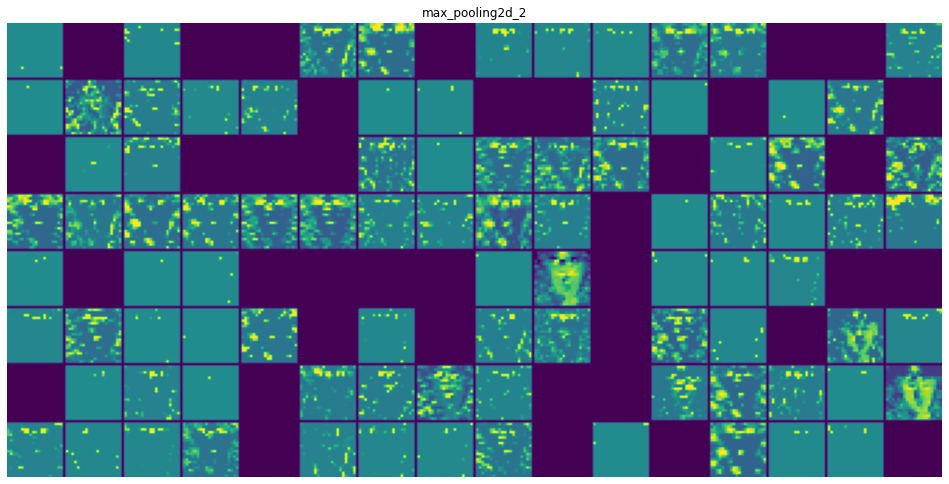

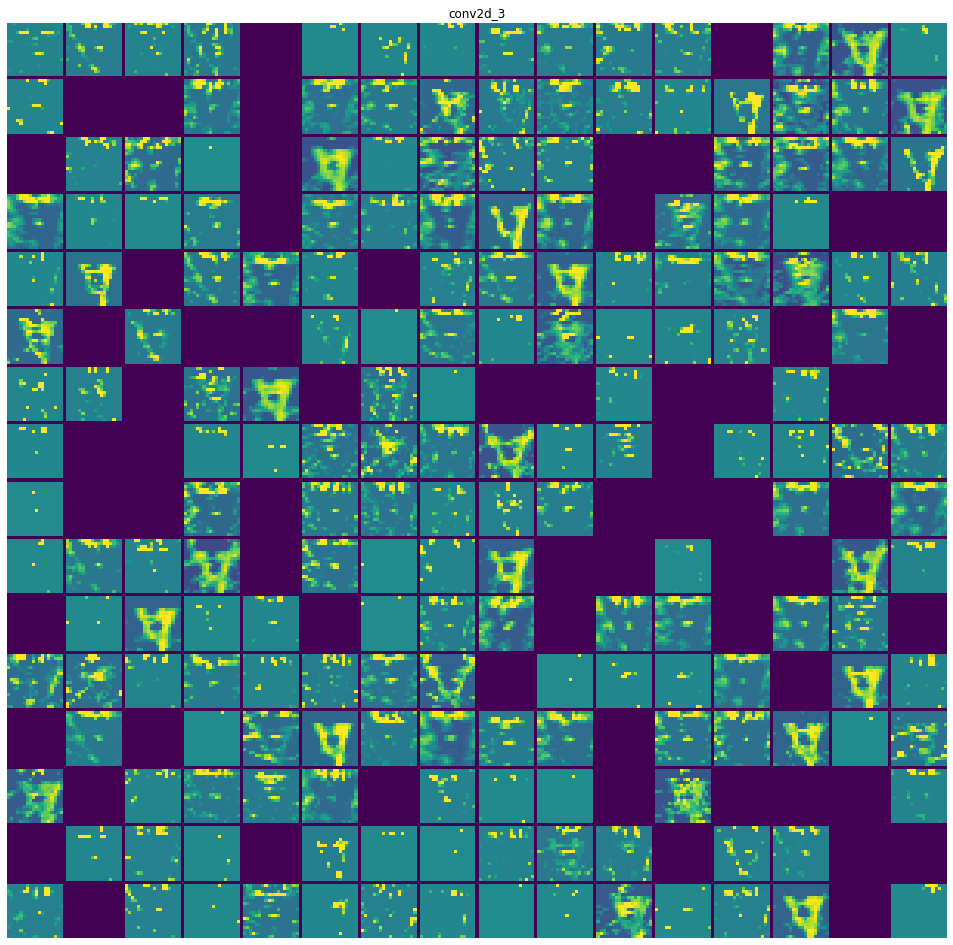

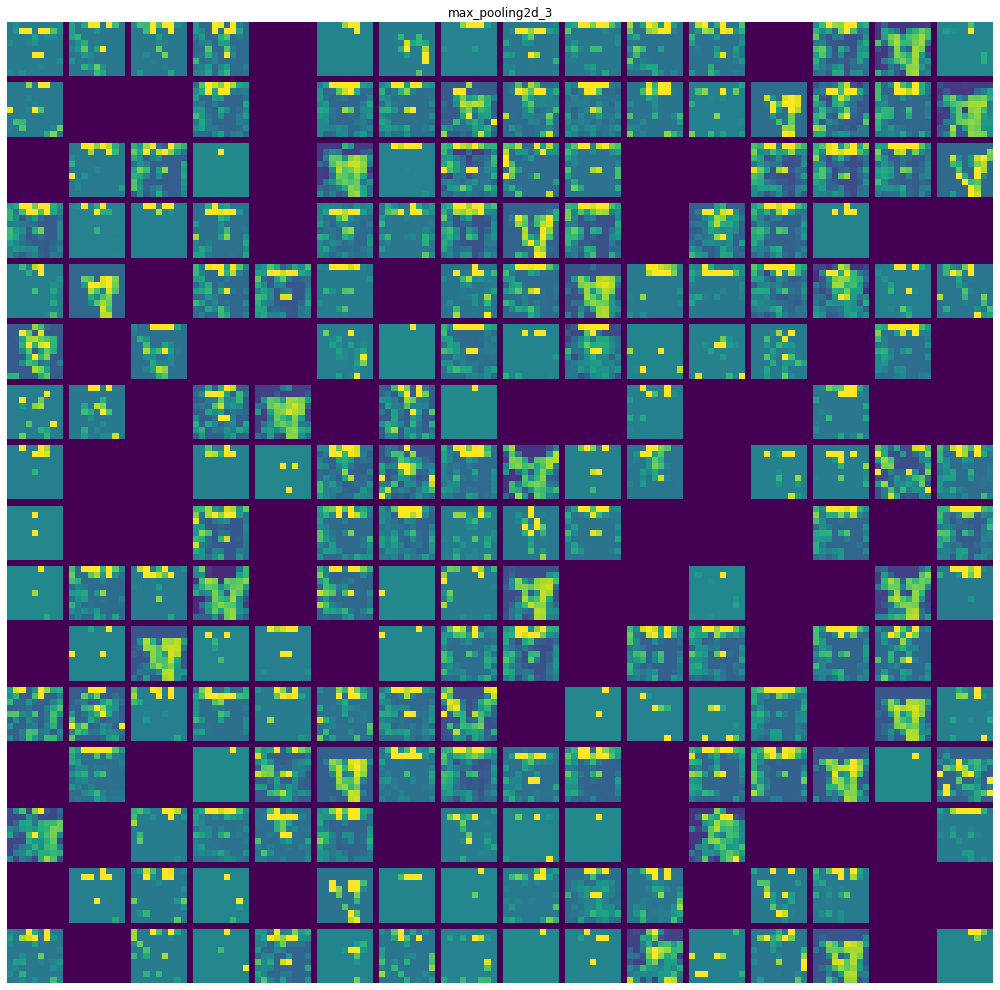

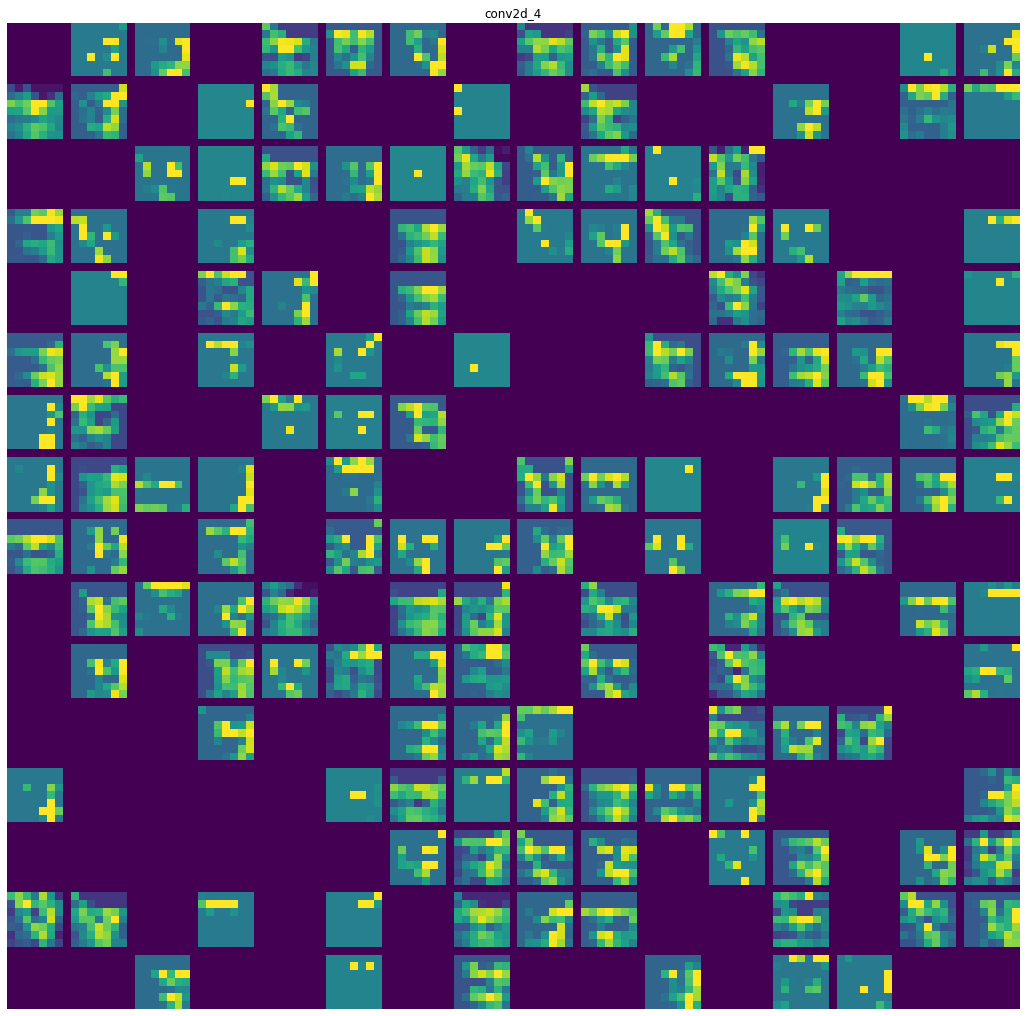

In [35]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

## Task 3

**Try the code on "Visualizing convnet filters". Show the visualization result for a randomly selected filter. (5 points)**

## Task 4

**Try the code on "Visualizing heatmaps of class activation". Show the visualization result on a randomly selected image from the cats-and-dogs dataset. (5 points)**